In [1]:
using Distributions
using Plots
using Random
using SpecialFunctions
using LaTeXStrings,StatsBase, BenchmarkTools


In [2]:
Random.seed!(123) # Setting the seed

@inline sample_sign() = [-1,1]|> rand
@inline uniform_sample() = Uniform() |> rand # Funcion para tomar muestras uniformes de [0,1]
@inline coin_flip() = Bernoulli() |> rand
@inline expo_sample() = Exponential() |> rand


expo_sample (generic function with 1 method)

In [3]:
uniform_sample

uniform_sample (generic function with 1 method)

## DEsigualdades


In [4]:
N = Normal()
f(x) = pdf(N,x)
mu = mean(N)
m = mode(N)
M = pdf(N,m)
sigma2 = std(N)

1.0

In [5]:
Mminus = 0.25
@assert Mminus <= M

In [6]:

#cota 1 Algoritmo LC-f-m
function g1(x,) 
    return [1, exp(1 - abs(x-m)*M) ] |> minimum |> p-> p*M
end

#cota 2 Algoritmo LC-f-mu-sigma
function g2(x)
    sigma = √sigma2
    if abs(x - mu) <= (1 + sqrt(3)) * sigma
        return 1/sigma
    elseif (1 + √3) * sigma <= abs(x-mu) <= (√3 + √12)*sigma
        return 1/(abs(x-mu) - sigma*√3)
    elseif abs(x-mu) >= (√3 + √12)*sigma2
        return 1/(sigma2 * √12) * exp(3/2 - (abs(x-mu))/(sigma * √12) )
    end

end

# cota 3 Algoritmo LC-f-mu
function g3(x)
    if abs(x-mu) <= (1 + 1/(ℯ * sqrt(3)))/f(mu)
        return f(mu)*ℯ*sqrt(3)
    elseif (1 + 1/(ℯ * sqrt(3)))/f(mu) <= abs(x-mu) <= 2/f(mu)
        return 1/(abs(x-mu) - 1/f(mu) )
    elseif abs(x-mu) >= 2/f(mu)
        return f(mu)* exp(2 - abs(x-mu)/f(mu) ) 

    end
end

# cota 4 Algoritmo LC-g-m
# Requiere de h tq h(m) = 1 y M_minus < M
function g4(x)
    return [1, exp(1 - abs(x-m)* Mminus)] |> minimum
end

#cota 5 Algoritmo LC-g-mu-sigma 
# Requiere de h ∝ f tal que h(mu) = 1 
g5(x) = [1, exp( 3/2 - abs(x -mu)/(√sigma2 * √12) ) ] |>
        minimum |>
        a -> a * ℯ * √3

# Cota 6 Algoritmo LC-g-m-sigma
# Requiere de h tq h(m) = 1
g6(x) = [1, exp(1 - (abs(x-m)/(√sigma2 * √12) ))] |>
        minimum


g6 (generic function with 1 method)

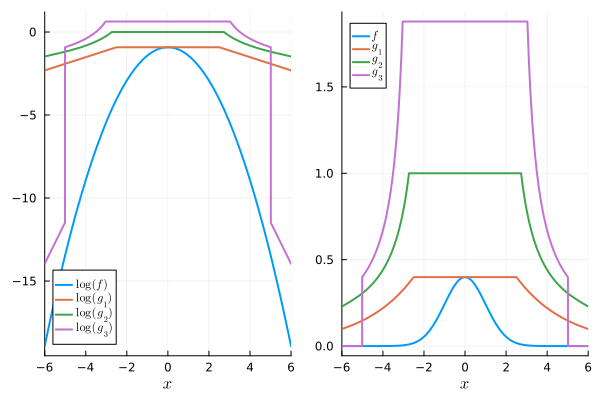

In [8]:
plt_log = plot( x-> x|> f |> log,
    xlims=(-6,6),
    lw=2,
    label=L"\log(f)")
plot!(
    [x-> x|> g1 |> log ,
    x-> x|> g2 |> log ,
    x-> x|> g3 |> log ],
    lw = 2,
    label=[L"\log(g_1)" L"\log(g_2)" L"\log(g_3)"]
)
xlabel!(L"x")




plt= plot( x-> x|> f ,
    xlims=(-6,6),
    lw=2,
    label=L"f")
plot!(
    [x-> x|> g1  ,
    x-> x|> g2  ,
    x-> x|> g3 ],
    lw = 2,
    label=[L"g_1" L"g_2" L"g_3"]
)
xlabel!(L"x")

final = plot(plt_log, plt)
#savefig(final, "cotas1.svg")


In [9]:
h1(x) = f(x)/f(m)


h1 (generic function with 1 method)

In [12]:
plt = plot( x-> x|> h1,
    xlims=(-10,10),
    lw=2,
    label=L"h_1")
plot!(f,
    lw=2,
    alpha= 0.7,
    style=:dot,
    label=L"f"
)

plot!([x-> x |> g4,
    x -> x |> g6],
    lw=2,
    label=[L"g_4" L"g_6"]
)
xlabel!(L"x")


plt_log = plot( x-> x|> h1|> log,
    xlims=(-10,10),
    lw=2,
    label=L"\log(h_1)")

plot!(x-> x|> f|> log,
    lw=2,
    alpha= 0.7,
    style=:dot,
    label=L"f"
)

plot!([x-> x |> g4 |> log,
    x -> x |> g6|> log],
    lw=2,
    label=[L"\log (g_4)" L"\log (g_6)"]
)
xlabel!(L"x")
final = plot(plt_log,plt,)
savefig(final, "cotas2.svg")


"/Users/robertito/Documents/repos/simulacion/cotas2.svg"

In [13]:
h2(x) = f(x)/f(mu)


h2 (generic function with 1 method)

In [21]:
plt = plot( x-> x|> h2,
    xlims=(-10,10),
    lw=2,
    label=L"h_2")

plot!(x-> x|> f,
    lw=2,
    alpha= 0.7,
    style=:dot,
    label=L"f"
)


plot!([x-> x |> g5],
    lw=2,
    label=L"g_5"
)
xlabel!(L"x")

plt_log = plot( x-> x|> h2|> log,
    xlims=(-10,10),
    lw=2,
    label=L"\log(h_2)"
)

plot!(x-> x|> f|> log,
    lw=2,
    alpha= 0.7,
    style=:dot,
    label=L"f"
)

plot!([x-> x |> g5 |> log],
    lw=2,
    label=L"\log(g_5)"
)


final = plot( plt_log, plt)
savefig(final, "cotas3.svg")

"/Users/robertito/Documents/repos/simulacion/cotas3.svg"

## Podemos calcular $f$ directamente

En este caso podemos evaluar la densidad $f$ y tenemos la locacion de la moda $m$


### Tenemos acesso SOLO a la localizacion de la moda

In [59]:
function algorithmfm(pdf, m)
    #algorithmLC-f-m
    M = pdf(m)
    accept = false
    rejected_n = 0

    while accept == false
        B = coin_flip()
        U = uniform_sample()
        S = sample_sign()

        if B==1
            V = uniform_sample()
            X = m + (S*V)/M
            if U*M <= pdf(X)
                return X, rejected_n
            else 
                rejected_n += 1
            end

        else
            E = expo_sample()
            X = m + S*((1+E)/M)

            if U*M*exp(-E) <= pdf(X)
                return X, rejected_n
            else
                rejected_n += 1 
            end

        end
    end
    return X, rejected_n
end


function algorithmLCfm2(pdf)
    # f is a decresing log-concave density on [0,inf) with mode f(0)=M=1
    M = pdf(0)
    U1 = Uniform() |> rand
    Z = U1
    accept = false

    while accept == false
        U2 = Uniform() |> rand
        Z = Z * U2
        Y = 1 + log(1/Z)
        U3 = Uniform() |> rand
        global X = U3 * Y
        accept = Z <= pdf(X)
    end
    
    return X
end

algorithmLCfm2 (generic function with 1 method)

Probamos ambos metodos

In [60]:
N = Normal(4,1)
f1(x) = pdf(N,x) # pdf de la distribucion Normal
m1 = mode(N);

sample1 = [algorithmfm(f1,m1) |> first for _ in 1:1000];

ecdf1 = ecdf(sample1)
cdf1(x) = cdf(N,x)



cdf1 (generic function with 1 method)

Summary Stats:
Length:         10
Missing Count:  0
Mean:           30070.900000
Std. Deviation: 394.412207
Minimum:        29585.000000
1st Quartile:   29733.000000
Median:         30052.000000
3rd Quartile:   30366.750000
Maximum:        30707.000000


In [93]:
r_counter |> sum

3042.0

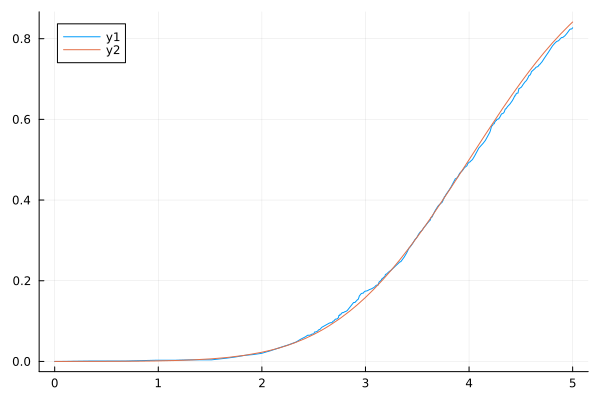

In [36]:
plot(x -> ecdf1(x), 0, 5)
plot!(cdf1)

In [37]:
E = Exponential()
f2(x) = pdf(E,x)

sample2 = [algorithmLCfm2(f2) for _ in 1:1000];

ecdf2 = ecdf(sample2)
cdf2(x) = cdf(E,x)


cdf2 (generic function with 1 method)

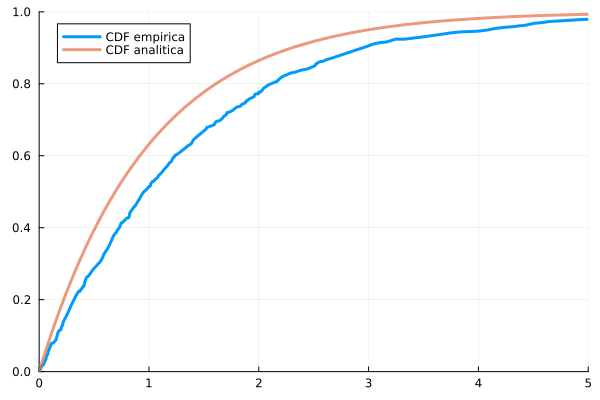

In [38]:
plot(x -> ecdf2(x), 0, 5,
    label="CDF empirica",
    lw=3
)
plot!(x -> cdf(E,x),
    label="CDF analitica",
    lw=3,
    alpha=0.7
)
xlims!(0,5)
ylims!(0,1)

Comparacion con los metodos de muestreo de Distributions.jl

In [43]:
# Muestreo de una normal usando el algorithmLC-f-m
@benchmark algorithmfm($f1,$m1)

BenchmarkTools.Trial: 10000 samples with 194 evaluations per sample.
 Range (min … max):  597.294 ns …  13.536 μs  ┊ GC (min … max): 0.00% … 91.66%
 Time  (median):     839.773 ns               ┊ GC (median):    0.00%
 Time  (mean ± σ):   887.851 ns ± 675.231 ns  ┊ GC (mean ± σ):  4.70% ±  5.75%

                       ▁▂▄▅▆▆▇▇▇███▇▆▅▅▃▂▁                       
  ▂▁▁▁▁▁▁▂▂▂▂▂▃▃▃▄▄▅▆███████████████████████▇▆▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂ ▅
  597 ns           Histogram: frequency by time         1.08 μs <

 Memory estimate: 721 bytes, allocs estimate: 33.

In [ ]:
# Muestreo de una normal usando el metodo default
@benchmark rand($N)

# Muestreo de una normal usando el algorithmLC-f-m
@benchmark algorithmfm($f1,$m1)

BenchmarkTools.Trial: 10000 samples with 1000 evaluations per sample.
 Range (min … max):  3.625 ns … 25.083 ns  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     4.375 ns              ┊ GC (median):    0.00%
 Time  (mean ± σ):   4.401 ns ±  0.518 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

                    ▁ ▃ ▄▅ ▆ ▇▃ █ █ ▆▆ ▄ ▃▁                   
  ▂▂▁▂▁▂▂▁▃▁▃▄▁▅▁▆▁▇█▁█▁██▁█▁██▇█▁█▁██▁█▁██▁█▁▇▁▆▅▁▄▁▄▃▁▃▁▃▂ ▄
  3.62 ns        Histogram: frequency by time        5.04 ns <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [70]:
sample = [algorithmfm(f,m) for i in 1:1000];

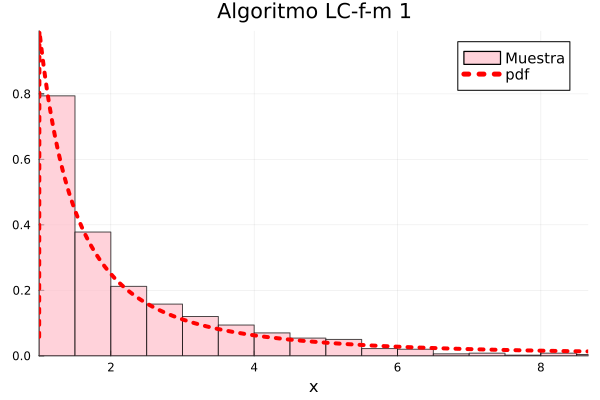

In [71]:
histogram(sample,normalize=:pdf,label="Muestra",alpha=0.7,color=:pink)
plot!(f,label="pdf",linestyle = :dot, lw=4.0,color=:red)
xlims!(1,maximum(sample))
plot!(legendfontsize=10)
xlabel!("x")
title!("Algoritmo LC-f-m 1")



In [77]:
N = Normal(0,1)
f(x) = pdf(N,x)/pdf(N,0)

f (generic function with 1 method)

In [73]:
sample = [algorithmLCfm2(f) for i in 1:1000];


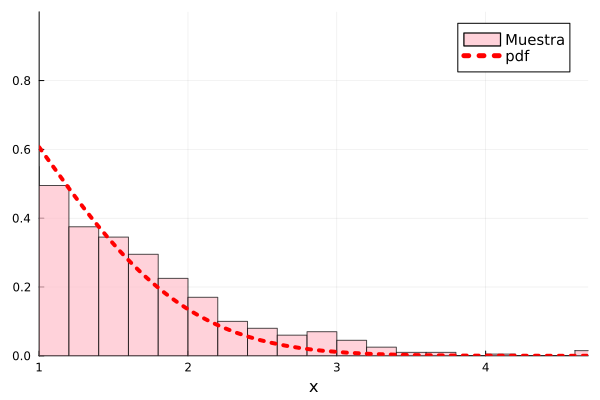

In [74]:
histogram(sample,normalize=:pdf,label="Muestra",alpha=0.7,color=:pink)
plot!(f,label="pdf",linestyle = :dot, lw=4.0,color=:red)
xlims!(1,maximum(sample))
plot!(legendfontsize=10)
xlabel!("x")

### Tenemos acesso a mu y sigma

In [46]:
function algorithmLCfmusigma2(pdf,sigma2,mu)
    # Algorithm lC-f-mu-sigma version 2
    p1 = 1 + sqrt(3)
    p2 = 1 + log(sqrt(12))
    p3 = 1

    q = p1 + p2 + p3

    sigma = sqrt(sigma2)
    accept = false

    while accept == false
        S = sample_sign()
        U = Uniform() |> rand
        V = Uniform() |> rand

        if V*q <= p1
            W = Uniform() |> rand
            X = mu + S*W*(1+sqrt(3))*sigma
            if U/sigma <= pdf(X)
                return X
            end

        elseif V*q <= p1 + p2 
            W = Uniform() |> rand
            Y = (sqrt(12))^W 
            X = mu + S * sigma * (sqrt(3) + Y)
            if U/(sigma * Y) <= pdf(X)
                return X
            end
        else 
            E = Exponential() |> rand
            X = mu + S * (sqrt(3) + sqrt(12) * (1 + E)) * sigma
            if U * exp(-E)/(sigma * sqrt(12)) <= pdf(X)
                return X
            end
        end
    end

end


algorithmLCfmusigma2 (generic function with 2 methods)

#### comparacion

In [ ]:
# Muestreo de una normal usando el algorithmLC-f-sigma2-mu
sigma2 = std(N)
mu = mean(N)
@benchmark algorithmLCfmusigma2($f1,$sigma2,$mu)

BenchmarkTools.Trial: 10000 samples with 47 evaluations per sample.
 Range (min … max):  706.553 ns … 56.898 μs  ┊ GC (min … max): 0.00% … 96.22%
 Time  (median):       1.262 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):     1.351 μs ±  1.779 μs  ┊ GC (mean ± σ):  4.97% ±  3.70%

                  ▁▁▂▄▅▆▆▆█▇███▇▇▅▄▄▂▃▁▁                        
  ▂▂▂▁▂▂▂▃▃▃▄▅▅▆▇▇███████████████████████▇▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂ ▅
  707 ns          Histogram: frequency by time         1.92 μs <

 Memory estimate: 868 bytes, allocs estimate: 27.

### Tenemos acceso solo a mu

In [78]:
function algorithmLCfmu(pdf,mu)

    #algorithm LC-f-mu version 1

    Mplus = pdf(mu) * exp(1) * sqrt(3) 
    Mminus = pdf(mu)
    
    p1 = 1 + exp(1)*sqrt(3)
    p2 = (1 + log(sqrt(3))) * log(Mplus/Mminus)
    p3 = 1
    q = p1 + p2 + p3

    accept = false

    while accept == false
        S = [-1,1] |> rand 
        U = Uniform() |> rand
        V = Uniform() |> rand


        if V * q <= p1
            W = Uniform() |> rand
            X = mu + S*W*(1+ sqrt(3))/Mplus

            if U*Mplus <= pdf(X)
                return X
            end
        elseif V*q <= p1 + p2
            W = Uniform() |> rand
            Y = (1 + sqrt(3))/(Mplus^W * Mminus^(1- W))
            X = mu + S*Y
            if (U*(1 + sqrt(3)))/Y <= pdf(X)
                return X
            end
        else
            E = Exponential() |> rand
            X = mu + S*(1 + sqrt(3) + E )/Mminus
            if U*Mminus*exp(E) <= pdf(X)
                return X
            end
        end
    end
    return X
    
end

algorithmLCfmu (generic function with 1 method)

In [81]:
@benchmark algorithmLCfmu($f1,$mu)

BenchmarkTools.Trial: 10000 samples with 10 evaluations per sample.
 Range (min … max):  737.500 ns … 226.204 μs  ┊ GC (min … max): 0.00% … 97.16%
 Time  (median):       2.371 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):     2.589 μs ±   5.442 μs  ┊ GC (mean ± σ):  5.02% ±  2.38%

               ▁▂▃▄▅▇▇█▆▇▇██▇▇▇▆▆▅▄▃▃▃▁▂                         
  ▁▁▁▁▁▂▂▃▄▄▆▆▇██████████████████████████▇▆▇▆▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁ ▅
  738 ns           Histogram: frequency by time         4.47 μs <

 Memory estimate: 808 bytes, allocs estimate: 41.

## La densidad solo se puede aproximar con una funcion proporcional

En este caso no podemos calcular $f$ directamente, solo tenemos aceso a una funcion $h$ tal que $h(x) = f(x)/f(m)$
A partir de setaconstante proponeos 

### Tenemos aceso a la locacion de la moda m

In [123]:
function algorithmLCgm(h,m,M_minus)
    # Algorithm LC-g-m version 1
    
    accept = false

    while accept == false
        
        B = Bernoulli() |> rand
        S = [1,-1] |> rand
        U = Uniform() |> rand
    
        if B == 1
            V = Uniform() |> rand
            X = m + (S*V)/M_minus
            if U <= h(X)
                return X
            end
        else 
            E = Exponential() |> rand
            X = m + S*(1+E)/M_minus
            if U*exp(-E) <= h(X)
                return X
            end
        end
    end
end



algorithmLCgm (generic function with 1 method)

In [ ]:
m1 |> f1 >= 0.25

Mminus = 0.25

g(x) = f1(x)/f1(m1)


3.753663895943657

In [106]:
@benchmark algorithmLCgm($g,$m1,$Mminus)

BenchmarkTools.Trial: 10000 samples with 186 evaluations per sample.
 Range (min … max):  818.995 ns …  14.809 μs  ┊ GC (min … max): 0.00% … 91.23%
 Time  (median):       1.081 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):     1.147 μs ± 818.321 ns  ┊ GC (mean ± σ):  4.69% ±  6.07%

               ▁▂▄▅▆▆██▇▇▅▅▄▂▂                                   
  ▁▁▁▁▁▁▂▂▃▃▄▆▆████████████████▇▆▆▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▃
  819 ns           Histogram: frequency by time         1.57 μs <

 Memory estimate: 861 bytes, allocs estimate: 34.

In [ ]:
# log gamma distribution

#a = 0.5

#f(x) = (exp(a*x - exp(x) ))/gamma(a)
#m = log(a)
#M = f(m)
#h(x) = exp(a*(x-m) + a - exp(x))
#M_minus = (a/(sqrt(2*pi*(a+1/2)))) * exp(1/(6*(a+3/8)))

0.24132528547775695

In [84]:
sample = [algorithmLCgm(h,m,M_minus) for i in 1:1000];


### Tenemos aceso a mu y sigma

In [130]:
function algorithmLCgmusigma(h,mu,sigma2)
    #algorithm LC-g-μ-σ version 1
    # Takes h prop to f such that h(mu) = 1
    # mu, sigma2 mean and std of f
    
    @assert h(mu) == 1
    accept = false

    while accept == false
        B = Bernoulli(3/5) |> rand
        S = [-1,1] |> rand 
        U = Uniform() |> rand

        if B == 1
            V = Uniform() |> rand
            X = mu + S*V*sqrt(sigma2)*sqrt(27)
            if U*exp(1)*sqrt(3) <= h(X)
                return X
            end
        else
            E = Exponential() |> rand
            X = mu + S*(1+E)*sqrt(sigma2)*sqrt(12)
            if U*sqrt(3)*exp(1-E) <= h(X)
                return X
            end
        end
    end
    return X
end


algorithmLCgmusigma (generic function with 1 method)

### tenemos acesso a m y sigma

In [ ]:
function algorithmLCgmigma(h,m,sigma2)
    # Algorithm LC-g-m-σ version 2
    
    @assert h(m) == 1
    accept = false

    while accept == false
        B = Bernoulli() |> rand
        S = [-1,1] |> rand 
        U = Uniform() |> rand

        if B == 1
            V = Uniform() |> rand
            X = m + S*V*sqrt(sigma2)*sqrt(12)
            if U <= h(X)
                return X 
            end 
        else
            E = Exponential() |> rand
            X = m + S*(1+E)*sqrt(sigma2)*sqrt(12)
            if U*exp(-E) <= h(X)
                return X 
            end
        end
    end    
end

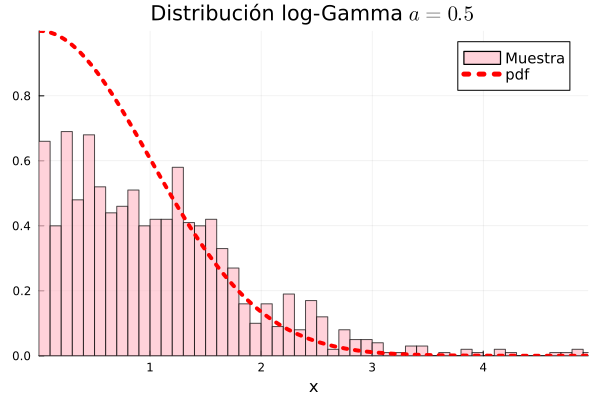

In [57]:
histogram(sample,normalize=:pdf,label="Muestra",alpha=0.7,color=:pink,bins=50)
plot!(f,label="pdf",linestyle = :dot, lw=4.0,color=:red)
xlims!(minimum(sample),maximum(sample))
plot!(legendfontsize=10)
xlabel!("x")
title!(L"Distribución log-Gamma $a = %$a $")

In [58]:
sample

1000-element Vector{Float64}:
 0.14910352951337516
 0.9073041909789331
 0.32289489575270386
 1.0880806942034282
 1.6125514944754453
 1.2892527381724384
 1.4221862785759296
 0.9553260759700315
 0.49821816642162897
 0.7104454018499192
 ⋮
 1.3301147480615874
 0.18606009323242953
 1.4972759870176429
 1.2024030813207838
 0.0325951355089867
 1.2055935889133829
 0.504712519639328
 1.590571980593997
 1.9613580605403396

In [60]:
function algorithmLCfmu(pdf,mu)

    #algorithm LC-f-mu version 1

    Mplus = pdf(mu) * exp(1) * sqrt(3) 
    Mminus = pdf(mu)
    
    p1 = 1 + exp(1)*sqrt(3)
    p2 = (1 + log(sqrt(3))) * log()
    p3 = 1
    q = p1 + p2 + p3

    accept = false

    while accept == false
        S = [-1,1] |> rand 
        U = Uniform() |> rand
        V = Uniform() |> rand


        if V * q <= p1
            W = Uniform() |> rand
            X = mu + S*(1+ 1/(exp(1)* sqrt(3)) )*W*1/Mminus
            accept = U*Mplus <= pdf(X)
        else if V*q <= p1 + p2
            W = Uniform() |> rand
            E = Exponential() |> rand
            X = m + S*(1+E)*sqrt(sigma2)*sqrt(12)
            accept = U*exp(-E) <= h(X)

        else 
            
        end
    end
    return X
    
end

function algorithmLCfmusigma(pdf,mu)

    #algorithm LC-f-mu-sigma2 version 1

    sigma = sqrt(sigma2)

    Mplus = 1/sigma
    Mminus = 1/(sigma*sqrt(12))
    
    p1 = 1 + exp(1)*sqrt(3)
    p2 = (1 + log(sqrt(3))) * log(Mplus/Mminus)
    p3 = 1
    q = p1 + p2 + p3

    accept = false

    while accept == false
        S = [-1,1] |> rand 
        U = Uniform() |> rand
        V = Uniform() |> rand


        if V * q <= p1
            W = Uniform() |> rand
            X = mu + S*(1+ 1/(exp(1)* sqrt(3)) )*W*1/Mminus
            accept = U*Mplus <= pdf(X)
        else if V*q <= p1 + p2
            W = Uniform() |> rand
            E = Exponential() |> rand
            X = m + S*(1+E)*sqrt(sigma2)*sqrt(12)
            accept = U*exp(-E) <= h(X)

        else 
            
        end
    end
    return X
    
end


ErrorException: syntax: use "elseif" instead of "else if"

In [61]:
function algorithmLCfmusigma2()
    # Algorithm lC-f-mu-sigma version 2
    p1 = 1 + sqrt(3)
    p2 = 1 + log(sqrt(12))
    p3 = 1

    q = p1 + p2 + p3

    sigma = sqrt(sigma2)
    accept = false

    while accept == false
        S = sample_sign()
        U = Uniform() |> rand
        V = Uniform() |> rand

        if V*q <= p1
            W = Uniform() |> rand
            X = mu + S*W*(1+sqrt(3))*sigma
            if U/sigma <= pdf(X)
                return X
            end

        elseif V*q <= p1 + p2 
            W = Uniform() |> rand
            Y = (sqrt(12))^W 
            X = mu + S * sigma * (sqrt(3) + Y)
            if U/(sigma * Y) <= pdf(X)
                return X
            end
        else 
            E = Exponential() |> rand
            X = mu + S * (sqrt(3) + sqrt(12) * (1 + E)) * sigma
            if U * exp(-E)/(sigma * sqrt(12)) <= pdf(X)
                return X
            end
        end
    end

end
            

algorithmLCfmusigma2 (generic function with 1 method)

In [62]:
function algorithmLCfmu2()
    # Algorithm LC-f-mu version 2
    p1 = 1 + exp(1)*sqrt(3)
    p2 = 1 + log(sqrt(3))
    p3 = 1

    q = p1 + p2 + p3

    Mplus = f(mu)*exp(1)*sqrt(3)
    Mminus = f(mu)

    accept = false

    while accept == false
        S = sample_sign()
        U = Uniform() |> rand
        V = Uniform() |> rand

        if V*q <= p1 
            W = Uniform() |> rand
            X = mu + S*(1+1/(exp(1)*sqrt(3)))*W*1/Mminus
            
            if U*Mplus <= pdf(X)
                return X
            end
        elseif V*q <= p1 + p2 
            W = Uniform() |> rand
            Y = 1/(Mplus^W * Mminus^(1-W))
            X = mu + S*(1/Mminus + Y)

            if U/Y <= pdf(X)
                return X
            end
        else 
            E = Exponential() |> rand
            X = mu + S*(2+E)/Mminus
            
            if U*Mminus*exp(-E) <= pdf(X)
                return X
            end
        end
    end

end


algorithmLCfmu2 (generic function with 1 method)

In [132]:
function algorithmLCgmigma(h,m,sigma2)
    # Algorithm LC-g-m-σ version 2
    
    @assert h(m) == 1
    accept = false

    while accept == false
        B = Bernoulli() |> rand
        S = [-1,1] |> rand 
        U = Uniform() |> rand

        if B == 1
            V = Uniform() |> rand
            X = m + S*V*sqrt(sigma2)*sqrt(12)
            if U <= h(X)
                return X 
            end 
        else
            E = Exponential() |> rand
            X = m + S*(1+E)*sqrt(sigma2)*sqrt(12)
            if U*exp(-E) <= h(X)
                return X 
            end
        end
    end    
end

algorithmLCgmigma (generic function with 1 method)

In [64]:
N = Normal(3,1)

μ = mean(N)
sigma2 = std(N)
m = mode(N)
f(x) = pdf(N,x)
h(x) = f(x)/f(μ)

h (generic function with 1 method)

In [65]:

sample=[algorithmLCgmigma(h,m,sigma2) for _ in 1:1000];

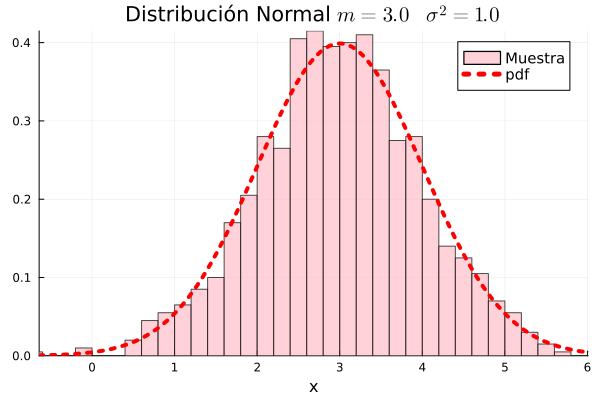

In [66]:
histogram(sample,normalize=:pdf,label="Muestra",alpha=0.7,color=:pink,bins=50)
plot!(f,label="pdf",linestyle = :dot, lw=4.0,color=:red)
xlims!(minimum(sample),maximum(sample))
plot!(legendfontsize=10)
xlabel!("x")
title!(L"Distribución Normal $m = %$μ \quad \sigma^2 = %$σ2 $")

## Benchmarks

Recordatorio

* Algoritmo 1: LC-f-m version 1
* Algoritmo 2: LC-f-m version 2 (solo para densidades entre 0 inf)
* Algoritmo 3: lC-f-mu-sigma version 2
* Algoritmo 4: LC-f-mu version 2
* Algoritmo 5: LC-g-m version 1
* Algoritmo 6: LC-g-mu-sigma version 1
* Algoritmo 7: LC-g-m-sigma version 2


In [127]:
N = Normal(4,1)
f1(x) = pdf(N,x) # pdf de la distribucion Normal
m1 = mode(N);
mu1 = mean(N)
sigma1 = std(N)
g1(x) = f(x)/f(m1) # g(x) = f(x)/f(m) tal que g(m) = 1

h1(x) = f(x)/f(mu1) #h(x) = f(x)/f(mu) s.a h(mu) = 1


E = Exponential() 
f2(x) = pdf(E,x) #PDF de distribucion exponencial

Mminus1 = 0.25 #Constant s.t f(m) >= Mminus
@assert f1(m1) >= Mminus1

In [114]:
# Muestreo de una normal usando el metodo default
@benchmark rand($N)

BenchmarkTools.Trial: 10000 samples with 1000 evaluations per sample.
 Range (min … max):  3.708 ns … 19.666 ns  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     4.375 ns              ┊ GC (median):    0.00%
 Time  (mean ± σ):   4.401 ns ±  0.517 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

                  ▁ ▂▄ ▆ ▇ █ ▇▇ ▇ ▆ ▅ ▃ ▃▁                    
  ▂▂▁▂▁▃▁▃▁▄▅▁▆▁▇▁█▁██▁█▁█▁█▁██▁█▁█▁█▁█▁██▁█▁▆▁▆▁▅▄▁▄▁▃▁▃▁▃▂ ▄
  3.71 ns        Histogram: frequency by time        5.04 ns <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [115]:
@benchmark algorithmfm($f1,$m1) #Algoritmo 1

BenchmarkTools.Trial: 10000 samples with 203 evaluations per sample.
 Range (min … max):  522.374 ns …  13.428 μs  ┊ GC (min … max): 0.00% … 92.43%
 Time  (median):     671.182 ns               ┊ GC (median):    0.00%
 Time  (mean ± σ):   724.862 ns ± 733.615 ns  ┊ GC (mean ± σ):  6.44% ±  6.01%

                  ▁▁▃▄▆▅█▇█▇▇▇▅▆▄▃▃▂                             
  ▁▁▁▁▁▁▁▂▂▂▃▄▅▅▇█████████████████████▇▆▅▅▄▄▄▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁ ▄
  522 ns           Histogram: frequency by time          873 ns <

 Memory estimate: 757 bytes, allocs estimate: 34.

In [116]:
@benchmark algorithmLCfm2($f2) # Algoritmo 2

BenchmarkTools.Trial: 10000 samples with 807 evaluations per sample.
 Range (min … max):  181.279 ns …   4.968 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     193.411 ns               ┊ GC (median):    0.00%
 Time  (mean ± σ):   204.625 ns ± 124.429 ns  ┊ GC (mean ± σ):  1.55% ± 3.92%

     ▃█▆▂                                                        
  ▂▃▆████▇▆▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▂▁▁▁▁▁▁▂▂▁▂▂▁▂ ▃
  181 ns           Histogram: frequency by time          319 ns <

 Memory estimate: 111 bytes, allocs estimate: 6.

In [117]:
# Muestreo de una normal usando el algorithmLC-f-sigma2-mu
@benchmark algorithmLCfmusigma2($f1,$sigma2,$mu) #Algoritmo 3

BenchmarkTools.Trial: 10000 samples with 112 evaluations per sample.
 Range (min … max):  742.554 ns … 24.621 μs  ┊ GC (min … max): 0.00% … 94.70%
 Time  (median):       1.073 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):     1.155 μs ±  1.253 μs  ┊ GC (mean ± σ):  6.47% ±  5.68%

                     ▁▁▃▃▄▅▅▆▇▇█▇▆▇▅▄▅▄▃▁▁▁                     
  ▂▁▂▂▂▂▂▂▃▃▃▃▄▄▅▆▇▇███████████████████████▇▇▆▅▆▅▅▄▄▃▃▃▃▃▃▃▃▂▂ ▅
  743 ns          Histogram: frequency by time          1.4 μs <

 Memory estimate: 1.03 KiB, allocs estimate: 33.

In [118]:
@benchmark algorithmLCfmu($f1,$mu) #Algoritmo 4

BenchmarkTools.Trial: 10000 samples with 10 evaluations per sample.
 Range (min … max):  637.500 ns … 271.871 μs  ┊ GC (min … max): 0.00% … 97.24%
 Time  (median):       2.004 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):     2.217 μs ±   5.941 μs  ┊ GC (mean ± σ):  6.41% ±  2.39%

                ▃▂▃▂▆▆▆▆█▆█▅▆▄▆▄▅▄▃▃▃ ▁                          
  ▁▁▁▁▂▂▃▃▄▄▅▅▆██████████████████████████▆▆▆▆▅▄▄▄▄▄▃▃▂▂▂▂▂▂▂▂▁▁ ▅
  638 ns           Histogram: frequency by time         3.81 μs <

 Memory estimate: 896 bytes, allocs estimate: 45.

In [ ]:
@benchmark algorithmLCgm($g1,$m1,$Mminus1) #Algoritmo 5

BenchmarkTools.Trial: 10000 samples with 193 evaluations per sample.
 Range (min … max):  591.321 ns …  19.410 μs  ┊ GC (min … max): 0.00% … 94.63%
 Time  (median):     725.176 ns               ┊ GC (median):    0.00%
 Time  (mean ± σ):   768.602 ns ± 654.707 ns  ┊ GC (mean ± σ):  4.33% ±  4.91%

                ▁▂▃▅▆▆█▇▇▆▆▅▄▂▁                                  
  ▁▁▁▁▁▂▂▂▃▃▅▅▆█████████████████▇▇▆▅▄▄▄▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▄
  591 ns           Histogram: frequency by time          957 ns <

 Memory estimate: 555 bytes, allocs estimate: 28.

In [ ]:
@benchmark algorithmLCgmusigma($h1,$mu1,$sigma1) #Algoritmo 6 

BenchmarkTools.Trial: 10000 samples with 141 evaluations per sample.
 Range (min … max):  903.369 ns …  17.843 μs  ┊ GC (min … max): 0.00% … 91.80%
 Time  (median):       1.048 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):     1.098 μs ± 812.810 ns  ┊ GC (mean ± σ):  3.91% ±  4.94%

                ▁▂▃▄▆▆▇▇█▇▇▇▇▆▅▃▃▂▁                              
  ▁▁▁▁▁▂▂▂▃▄▄▅▇▇█████████████████████▆▆▅▅▄▃▃▃▃▂▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁ ▄
  903 ns           Histogram: frequency by time         1.26 μs <

 Memory estimate: 836 bytes, allocs estimate: 45.

In [134]:
@benchmark algorithmLCgmigma($g1,$m1,$sigma1) #Algoritmo 7

BenchmarkTools.Trial: 10000 samples with 70 evaluations per sample.
 Range (min … max):  817.857 ns … 33.922 μs  ┊ GC (min … max): 0.00% … 95.05%
 Time  (median):       1.027 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):     1.077 μs ±  1.162 μs  ┊ GC (mean ± σ):  3.97% ±  3.56%

                   ▂▃▄▆▆▇█▇▇▇▇█▆▆▆▄▃▃▂▁▁                        
  ▂▂▂▁▂▂▃▃▃▃▄▅▅▆▇▇██████████████████████▇▆▆▅▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂ ▅
  818 ns          Histogram: frequency by time         1.28 μs <

 Memory estimate: 724 bytes, allocs estimate: 39.

## Place Holder

In [ ]:
function algorithmLCgmusigma(h,mu,sigma2)
    #algorithm LC-g-μ-σ version 1
    # Takes h prop to f such that h(mu) = 1
    # mu, sigma2 mean and std of f
    
    @assert h(mu) == 1
    accept = false

    while accept == false
        B = Bernoulli(3/5) |> rand
        S = [-1,1] |> rand 
        U = Uniform() |> rand

        if B == 1
            V = Uniform() |> rand
            X = mu + S*V*sqrt(sigma2)*sqrt(27)
            if U*exp(1)*sqrt(3) <= h(X)
                return X
            end
        else
            E = Exponential() |> rand
            X = mu + S*(1+E)*sqrt(sigma2)*sqrt(12)
            if U*sqrt(3)*exp(1-E) <= h(X)
                return X
            end
        end
    end
    return X
end

algorithmLCgmusigma (generic function with 1 method)

In [187]:
N = Normal(3,1)

μ = mean(N)
σ2 = std(N)

f(x) = pdf(N,x)
h(x) = f(x)/f(μ)



h (generic function with 1 method)

In [189]:
sample=[algorithmLCgmusigma(h,μ,σ2) for _ in 1:1000];

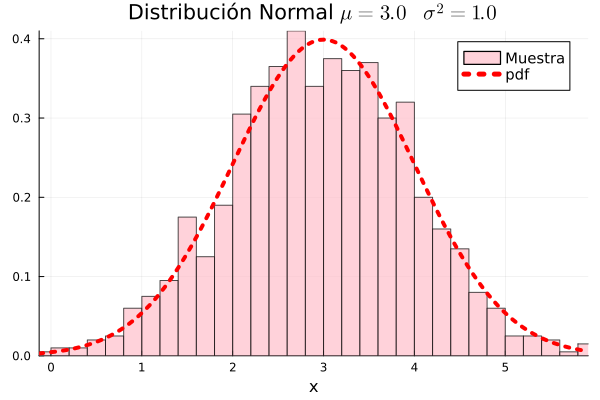

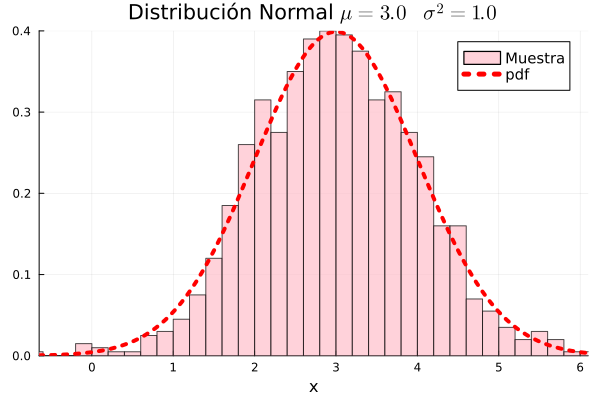

In [192]:
histogram(sample,normalize=:pdf,label="Muestra",alpha=0.7,color=:pink,bins=50)
plot!(f,label="pdf",linestyle = :dot, lw=4.0,color=:red)
xlims!(minimum(sample),maximum(sample))
plot!(legendfontsize=10)
xlabel!("x")
title!(L"Distribución Normal $\mu = %$μ \quad \sigma^2 = %$σ2 $")

In [ ]:
\e


ErrorException: syntax: "\" is not a unary operator

ErrorException: syntax: "\" is not a unary operator

In [38]:
x = 1


1